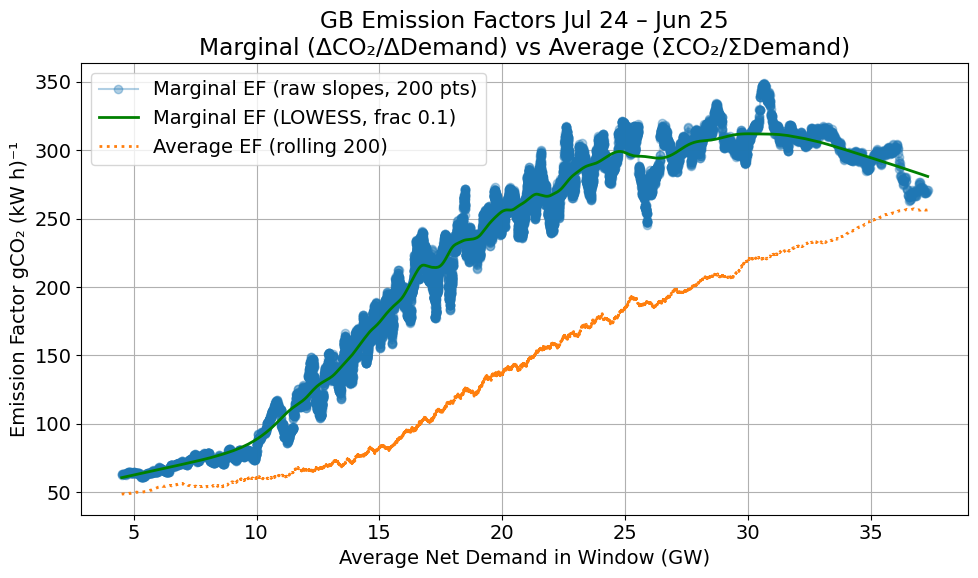

In [1]:
# Now adjusted to use averages of demand, rather than medians of demand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === GLOBAL FONT SIZES (min 14) ===
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Δ from t to t+1, aligned to time t
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift and any missing intensity)
df_filtered = df.dropna(subset=['GBNetDemand', 'CO2_Net', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression & average emission factor ===
window_size = 200
slopes = []
avg_demands = []
aefs = []  # average emission factors for each window

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]

    # Rolling regression (marginal EF) through the origin
    x = window['Δ_NetDemand'].values.reshape(-1, 1)  # keep in MW for correct EF units
    y = window['Δ_CO2'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False).fit(x, y)
    slopes.append(reg.coef_[0][0])

    # Average demand for x-axis (in MW for now)
    avg_demands.append(window['NetDemand_t'].mean())

    # Average EF over the window: sum(CO2_Net) / sum(NetDemand)
    denom = window['NetDemand_t'].sum()
    aef = window['CO2_Net'].sum() / denom if denom != 0 else np.nan
    aefs.append(aef)

# ---- Convert x-axis to GW ----
avg_demands_gw = np.asarray(avg_demands, dtype=float) / 1000.0

# LOWESS smooth the marginal EF series using GW on x-axis
lowess = sm.nonparametric.lowess
lowess_result = lowess(slopes, avg_demands_gw, frac=0.1)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(avg_demands_gw, slopes, marker='o', linestyle='-', alpha=0.35,
         label='Marginal EF (raw slopes, 200 pts)')
plt.plot(lowess_result[:, 0], lowess_result[:, 1],color='green', linewidth=2,
         label='Marginal EF (LOWESS, frac 0.1)')
plt.plot(avg_demands_gw, aefs, linestyle=':', linewidth=2,
         label='Average EF (rolling 200)')

plt.title('GB Emission Factors Jul 24 – Jun 25\nMarginal (ΔCO₂/ΔDemand) vs Average (ΣCO₂/ΣDemand)')
plt.xlabel('Average Net Demand in Window (GW)')
plt.ylabel('Emission Factor gCO₂ (kW h)⁻¹')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


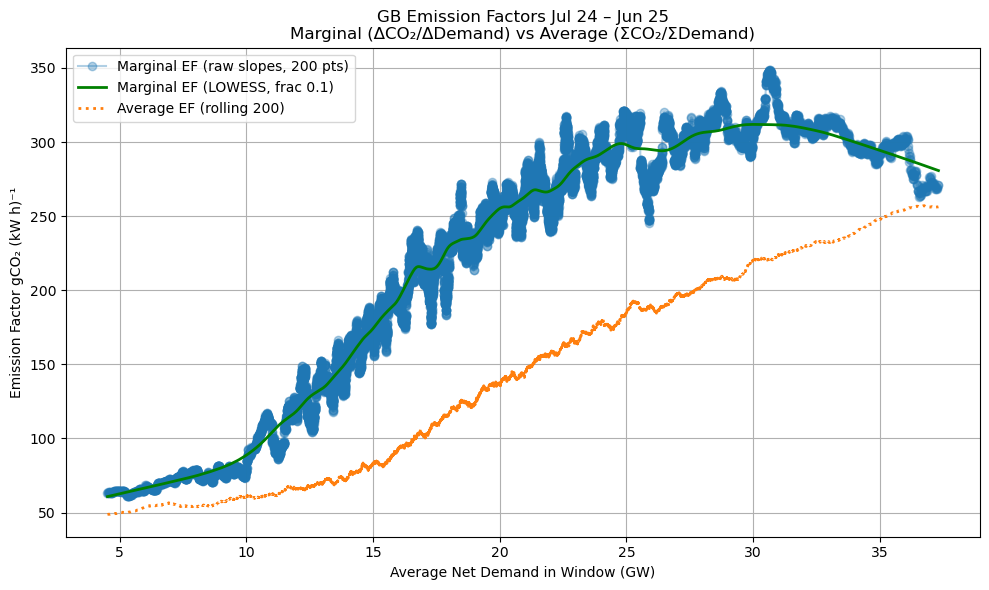

In [24]:
# Now adjusted to use averages of demand, rather than medians of demand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Δ from t to t+1, aligned to time t
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift and any missing intensity)
df_filtered = df.dropna(subset=['GBNetDemand', 'CO2_Net', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression & average emission factor ===
window_size = 200
slopes = []
avg_demands = []
aefs = []  # average emission factors for each window

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]

    # Rolling regression (marginal EF) through the origin
    x = window['Δ_NetDemand'].values.reshape(-1, 1)  # keep in MW for correct EF units
    y = window['Δ_CO2'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False).fit(x, y)
    slopes.append(reg.coef_[0][0])

    # Average demand for x-axis (in MW for now)
    avg_demands.append(window['NetDemand_t'].mean())

    # Average EF over the window: sum(CO2_Net) / sum(NetDemand)
    denom = window['NetDemand_t'].sum()
    aef = window['CO2_Net'].sum() / denom if denom != 0 else np.nan
    aefs.append(aef)

# ---- Convert x-axis to GW ----
avg_demands_gw = np.asarray(avg_demands, dtype=float) / 1000.0

# LOWESS smooth the marginal EF series using GW on x-axis
lowess = sm.nonparametric.lowess
lowess_result = lowess(slopes, avg_demands_gw, frac=0.1)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(avg_demands_gw, slopes, marker='o', linestyle='-', alpha=0.35,
         label='Marginal EF (raw slopes, 200 pts)')
plt.plot(lowess_result[:, 0], lowess_result[:, 1],color='green', linewidth=2,
         label='Marginal EF (LOWESS, frac 0.1)')
plt.plot(avg_demands_gw, aefs, linestyle=':', linewidth=2,
         label='Average EF (rolling 200)')

plt.title('GB Emission Factors Jul 24 – Jun 25\nMarginal (ΔCO₂/ΔDemand) vs Average (ΣCO₂/ΣDemand)')
plt.xlabel('Average Net Demand in Window (GW)')
plt.ylabel('Emission Factor gCO₂ (kW h)⁻¹')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


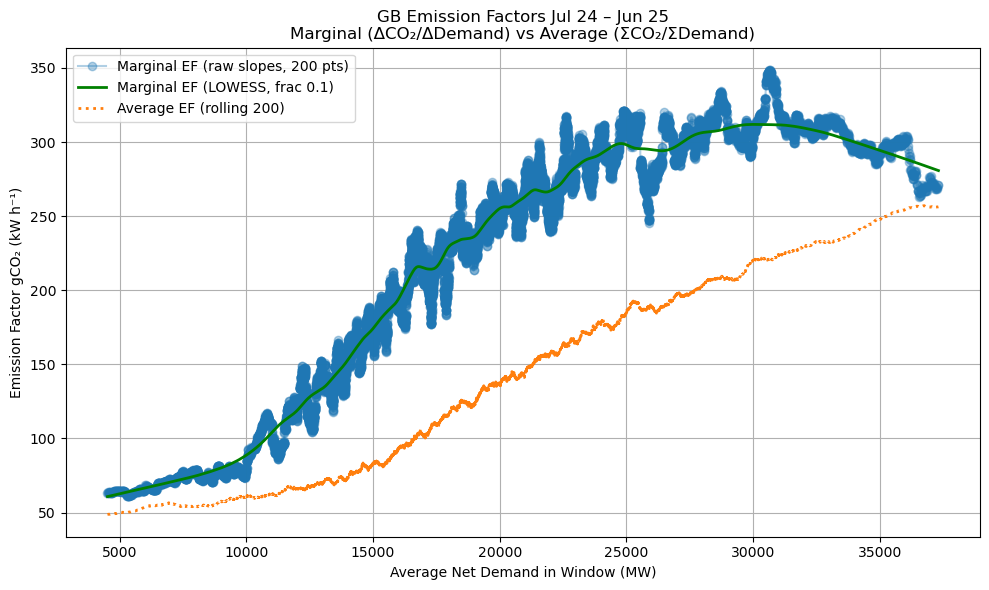

In [ ]:
#Now adjusted to use averages of demand, rather than medians of demand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Δ from t to t+1, aligned to time t
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift and any missing intensity)
df_filtered = df.dropna(subset=['GBNetDemand', 'CO2_Net', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression & average emission factor ===
window_size = 200
slopes = []
avg_demands = []
aefs = []  # average emission factors for each window

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]

    # Rolling regression (marginal EF) through the origin
    x = window['Δ_NetDemand'].values.reshape(-1, 1)
    y = window['Δ_CO2'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False).fit(x, y)
    slopes.append(reg.coef_[0][0])

    # Average demand for x-axis
    avg_demands.append(window['NetDemand_t'].mean())

    # Average EF over the window: sum(CO2_Net) / sum(NetDemand)
    denom = window['NetDemand_t'].sum()
    aef = window['CO2_Net'].sum() / denom if denom != 0 else np.nan
    aefs.append(aef)

# Optional: collapse any identical average-demand x-values (helps de-duplicate points)
# import pandas as pd
# tmp = pd.DataFrame({'avg_demand': avg_demands, 'slope': slopes, 'aef': aefs}).dropna()
# tmp = tmp.groupby('avg_demand', as_index=False).mean()
# avg_demands = tmp['avg_demand'].to_list()
# slopes = tmp['slope'].to_list()
# aefs = tmp['aef'].to_list()

# LOWESS smooth the marginal EF series (as before), now using average demands
lowess = sm.nonparametric.lowess
lowess_result = lowess(slopes, avg_demands, frac=0.1)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(avg_demands, slopes, marker='o', linestyle='-', alpha=0.35, label='Marginal EF (raw slopes, 200 pts)')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='Marginal EF (LOWESS, frac 0.1)')
plt.plot(avg_demands, aefs, linestyle=':', linewidth=2, label='Average EF (rolling 200)')

plt.title('GB Emission Factors Jul 24 – Jun 25\nMarginal (ΔCO₂/ΔDemand) vs Average (ΣCO₂/ΣDemand)')
plt.xlabel('Average Net Demand in Window (MW)')
plt.ylabel('Emission Factor gCO₂ (kW h)⁻¹')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd

# === Load the original dataset ===
input_csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(input_csv_path)

# === LOWESS result must already be in memory ===
# Example (from prior step): lowess_result = sm.nonparametric.lowess(slopes, avg_demands, frac=0.1)

# Extract x and y from LOWESS result (x = AVERAGE Net Demand, y = smoothed slopes)
x_lowess = np.asarray(lowess_result[:, 0], dtype=float)
y_lowess = np.asarray(lowess_result[:, 1], dtype=float)

# Ensure x is strictly non-decreasing for interpolation
order = np.argsort(x_lowess)
x_lowess = x_lowess[order]
y_lowess = y_lowess[order]

# Define interpolation with clipping at the ends
def interpolate_with_bounds(x_vals, x_ref, y_ref):
    x_vals = np.asarray(x_vals, dtype=float)
    # np.interp handles interior points; left/right provide flat extrapolation at bounds
    return np.interp(x_vals, x_ref, y_ref, left=y_ref[0], right=y_ref[-1])

# Interpolate LOWESS values for each GBNetDemand entry (mask NaNs to avoid errors)
mask = df['GBNetDemand'].notna()
df.loc[mask, 'MarginalEF_LOWESS'] = interpolate_with_bounds(df.loc[mask, 'GBNetDemand'], x_lowess, y_lowess)

# === Save to a new file ===
output_csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_LOWESS_avgDemand.csv"
df.to_csv(output_csv_path, index=False)

print(f"LOWESS-smoothed marginal emission factors (vs average demand) saved to:\n{output_csv_path}")


LOWESS-smoothed marginal emission factors (vs average demand) saved to:
C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_LOWESS_avgDemand.csv


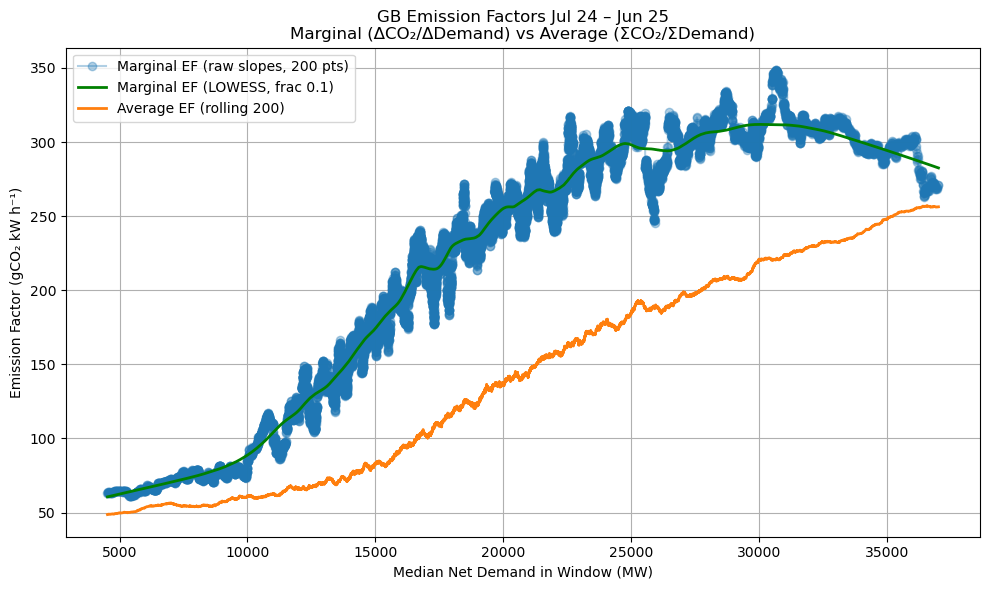

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Δ from t to t+1, aligned to time t
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift and any missing intensity)
df_filtered = df.dropna(subset=['GBNetDemand', 'CO2_Net', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression & average emission factor ===
window_size = 200
slopes = []
medians = []
aefs = []  # average emission factors for each window

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]

    # Rolling regression (marginal EF)
    x = window['Δ_NetDemand'].values.reshape(-1, 1)
    y = window['Δ_CO2'].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False).fit(x, y)
    slopes.append(reg.coef_[0][0])

    # Median demand for x-axis
    medians.append(window['NetDemand_t'].median())

    # Average EF over the window: sum(CO2_Net) / sum(NetDemand)
    denom = window['NetDemand_t'].sum()
    aef = window['CO2_Net'].sum() / denom if denom != 0 else np.nan
    aefs.append(aef)

# LOWESS smooth the marginal EF series (as before)
lowess = sm.nonparametric.lowess
lowess_result = lowess(slopes, medians, frac=0.1)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(medians, slopes, marker='o', linestyle='-', alpha=0.35, label='Marginal EF (raw slopes, 200 pts)')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='Marginal EF (LOWESS, frac 0.1)')
plt.plot(medians, aefs, linestyle='-', linewidth=2, label='Average EF (rolling 200)')

plt.title('GB Emission Factors Jul 24 – Jun 25\nMarginal (ΔCO₂/ΔDemand) vs Average (ΣCO₂/ΣDemand)')
plt.xlabel('Median Net Demand in Window (MW)')
plt.ylabel('Emission Factor (gCO₂ kW h⁻¹)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import pandas as pd

# === Load the original dataset ===
input_csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(input_csv_path)

# === LOWESS result must already be in memory ===
# Example: lowess_result = sm.nonparametric.lowess(...)

# Extract x and y from LOWESS result
x_lowess = lowess_result[:, 0]  # Median Net Demands
y_lowess = lowess_result[:, 1]  # Smoothed slopes

# Define interpolation function with bounding
def interpolate_with_bounds(x_vals, x_lowess, y_lowess):
    x_min, x_max = x_lowess[0], x_lowess[-1]
    y_min, y_max = y_lowess[0], y_lowess[-1]
    x_vals = np.asarray(x_vals)

    y_interp = np.interp(x_vals, x_lowess, y_lowess)
    y_interp[x_vals < x_min] = y_min
    y_interp[x_vals > x_max] = y_max
    return y_interp

# Interpolate LOWESS values for each GBNetDemand entry
df['MarginalEF_LOWESS'] = interpolate_with_bounds(df['GBNetDemand'], x_lowess, y_lowess)

# === Save to a new file ===
output_csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_LOWESS.csv"
df.to_csv(output_csv_path, index=False)

print(f"LOWESS-smoothed marginal emission factors saved to:\n{output_csv_path}")


LOWESS-smoothed marginal emission factors saved to:
C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_with_LOWESS.csv


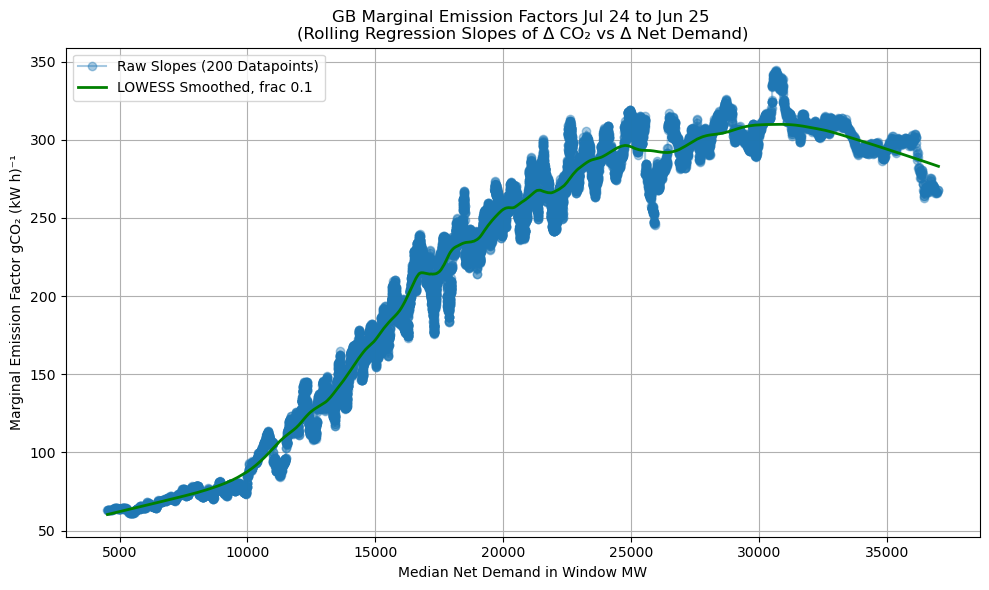

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Shift so demand_t aligns with Δ from t to t+1
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift)
df_filtered = df.dropna(subset=['GBNetDemand', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression ===
window_size = 200
slopes = []
medians = []

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]
    x = window['Δ_NetDemand'].values.reshape(-1, 1)
    y = window['Δ_CO2'].values.reshape(-1, 1)

    # Fit regression
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0][0])
    medians.append(window['NetDemand_t'].median())

import statsmodels.api as sm

lowess = sm.nonparametric.lowess
lowess_result = lowess(slopes, medians, frac=0.1)  # frac = smoothing factor (e.g., 0.1–0.3)

plt.figure(figsize=(10, 6))
plt.plot(medians, slopes, marker='o', linestyle='-', alpha=0.4, label='Raw Slopes (200 Datapoints)')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS Smoothed, frac 0.1')
plt.title('GB Marginal Emission Factors Jul 24 to Jun 25 \n(Rolling Regression Slopes of Δ CO₂ vs Δ Net Demand)')
plt.xlabel('Median Net Demand in Window MW')
plt.ylabel('Marginal Emission Factor gCO₂ (kW h)⁻¹')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

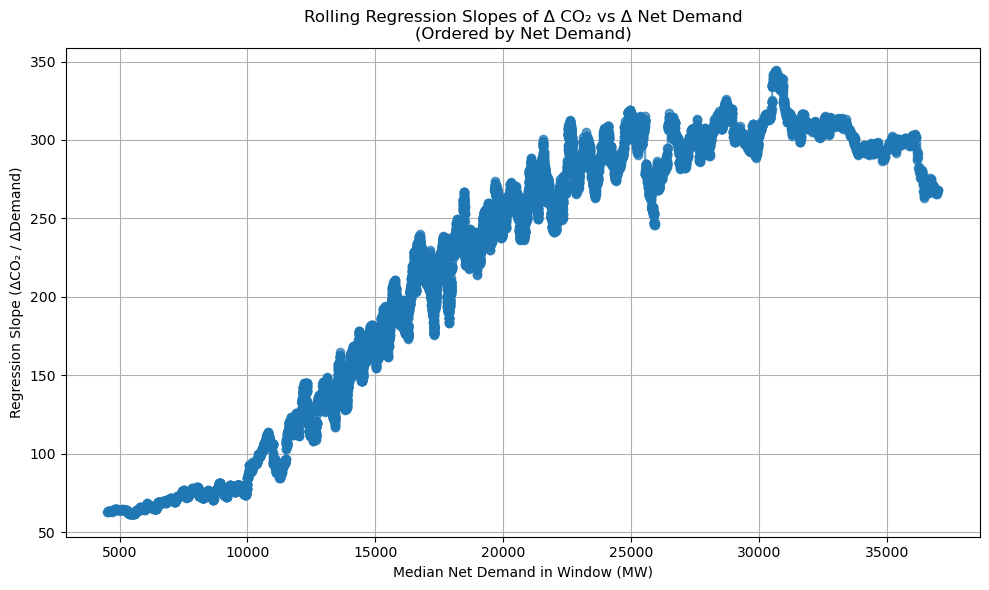

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# Compute CO₂ and deltas
df['CO2_Net'] = df['GBNetDemand'] * df['CarbonIntensityActualGB']
df['Δ_NetDemand'] = df['GBNetDemand'].diff().shift(-1)  # Shift so demand_t aligns with Δ from t to t+1
df['Δ_CO2'] = df['CO2_Net'].diff().shift(-1)

# Drop rows with NaNs (from diff/shift)
df_filtered = df.dropna(subset=['GBNetDemand', 'Δ_NetDemand', 'Δ_CO2']).copy()

# Rename for clarity
df_filtered = df_filtered.rename(columns={'GBNetDemand': 'NetDemand_t'})

# Sort by NetDemand
df_sorted = df_filtered.sort_values('NetDemand_t').reset_index(drop=True)

# === Rolling regression ===
window_size = 200
slopes = []
medians = []

for i in range(len(df_sorted) - window_size + 1):
    window = df_sorted.iloc[i:i + window_size]
    x = window['Δ_NetDemand'].values.reshape(-1, 1)
    y = window['Δ_CO2'].values.reshape(-1, 1)

    # Fit regression
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0][0])
    medians.append(window['NetDemand_t'].median())

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(medians, slopes, marker='o', linestyle='-', alpha=0.7)
plt.title('Rolling Regression Slopes of Δ CO₂ vs Δ Net Demand\n(Ordered by Net Demand)')
plt.xlabel('Median Net Demand in Window (MW)')
plt.ylabel('Regression Slope (ΔCO₂ / ΔDemand)')
plt.grid(True)
plt.tight_layout()
plt.show()
